# Trickng ResNet18 Image Classifier Using LLM Suggested Image Perturbations

In [41]:
# Check GPU
!nvidia-smi --query-gpu=name --format=csv,noheader

NVIDIA A100-SXM4-40GB


In [42]:
# pip install missing packages from main implementation
!pip install -U bitsandbytes
!pip install -q transformers accelerate bitsandbytes torch
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-jcu4gsz6
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-jcu4gsz6
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done


In [43]:
import re
import urllib
from google.colab import userdata
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
import torch
import json
import numpy as np
from PIL import Image, ImageEnhance
import cv2
import matplotlib.pyplot as plt
from torchvision import transforms, datasets
import clip


In [44]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [45]:
# Test images
# url, filename = ("https://github.com/pytorch/hub/raw/master/images/dog.jpg", "dog.jpg")
# try: urllib.URLopener().retrieve(url, filename)
# except: urllib.request.urlretrieve(url, filename)
# img = Image.open(filename)

In [46]:
# Authenticate with token
# Retrieves token: Assumes that everyone needs their own hugging face account and add token to colab env
hf_token = userdata.get('HF_TOKEN')

# Load model with authentication
model_id = "meta-llama/Meta-Llama-3-8B-Instruct"
tokenizer = AutoTokenizer.from_pretrained(model_id, token=hf_token)
llm_model = AutoModelForCausalLM.from_pretrained(
    model_id,
    token=hf_token,
    quantization_config=BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_compute_dtype=torch.float16
    ),
    device_map="auto"
)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [47]:
#Test that the model and image loading worked
def generate_response(prompt, max_new_tokens=50):
    inputs = tokenizer(prompt, return_tensors="pt").to(device)
    outputs = llm_model.generate(**inputs, max_new_tokens=max_new_tokens)
    return tokenizer.decode(outputs[0], skip_special_tokens=True)


PROMPTING

In [48]:
# perturbations_prompt = "Give locations, size, and type of perturbations to be done to an image. The image size is 1920 by 1080 and the maximum perturbation size is 100 by 100. Give a list of 10 perturbations which specify pixel location, size of the perturbation patch, channel an integer between 0 and 3, and type of perturbation. Respond only in JSON format with no explainations."

# perturbation_examples = """  {"location": [20, 30], "size": [10, 10], "channel": 0, "type": "gaussian_noise"},
#   {"location": [50, 60], "size": [8, 8], "channel": 0, "type": "blur"},
#   {"location": [70, 20], "size": [6, 6], "channel": 1, "type": "occlusion"},
#   {"location": [10, 10], "size": [9, 9], "channel": 2, "type": "brightness_increase"},
#   {"location": [80, 40], "size": [7, 7], "channel": 0, "type": "contrast_decrease"},
#   {"location": [30, 70], "size": [10, 10], "channel": 1, "type": "salt_and_pepper_noise"},
#   {"location": [60, 15], "size": [5, 5], "channel": 2, "type": "motion_blur"},
#   {"location": [25, 85], "size": [6, 6], "channel": 1, "type": "color_shift"},
#   {"location": [90, 90], "size": [10, 10], "channel": 2, "type": "sharpen"},
#   {"location": [40, 50], "size": [7, 7], "channel": 0, "type": "grayscale"}
#   """

# ranks = [0.9,1,0.2,0.3,0.1,0.5,0,0.2,0.2,0.8]



In [49]:
perturbations_prompt = "Give types of perturbations to be done to an image. The image size is 256 by 256.\
Give a list of up to 10 perturbations where operations are one of these: [rotate, adjust_brightness, blur_patch, add_stripe_noise, add_patch, translate].\
Rotate requires an angle parameter.\
adjust_brightness requires a factor parameter.\
blur_patch requires center, radius, and sigma parameters.\
add_stripe_noise requires orientation, stripe_width, intensity, and location.\
add_patch requires location, size, and type parameters with an option color parameter.\
translate requires x_shift and y_shift parameters.\
Respond only in JSON format with no explainations."

perturbation_examples = """
    [{
            "operation": "rotate",
            "angle": 15
    },
    {
            "operation": "adjust_brightness",
            "factor": 1.5
    },
    {
            "operation": "blur_patch",
            "center": [80, 60],
            "radius": 20,
            "sigma": 5.0
    },
    {
            "operation": "add_stripe_noise",
            "orientation": "horizontal",
            "stripe_width": 10,
            "intensity": 0.1,
            "location": 0.3
    },
    {
            "operation": "add_patch",
            "location": [50, 50],
            "size": [40, 40],
            "type": "noise"
    },
    {
            "operation": "add_patch",
            "location": [120, 120],
            "size": [30, 30],
            "type": "color",
            "color": [255, 0, 0]
    },
    {
            "operation": "translate",
            "x_shift": 20,
            "y_shift": 30
    }]"""

In [50]:
# original prompt is below:
# f"Give types of perturbations to be done to an image. The image size is {size[0]} by {size[1]}.\
# Give a list of up to 10 perturbations where operations are one of these: [rotate, adjust_brightness, blur_patch, add_stripe_noise, add_patch, translate].\
# Rotate requires an angle parameter.\
# adjust_brightness requires a factor parameter.\
# blur_patch requires center, radius, and sigma parameters.\
# add_stripe_noise requires orientation, stripe_width, intensity, and location.\
# add_patch requires location, size, and type parameters with an option color parameter.\
# translate requires x_shift and y_shift parameters.\
# Respond only in JSON format with no explainations."

In [73]:
def generate_new_perturbations_prompt(prev_pert = perturbation_examples, ranks = [], size = [224,224]):
  init_prompt = f"Give a list of up to 10 image perturbations that can trick ResNet's image classifier into misclassifying the perturbed image while keeping the perturbed image as close to the original one as possible. Strictly follow these guidelines:"
  base_prompt = f"\
Operations are exclusively one of these: [rotate, adjust_brightness, blur_patch, add_stripe_noise, add_patch, translate].\
The image size is {size[0]} by {size[1]}.\
Rotate requires an angle parameter.\
adjust_brightness requires a factor parameter.\
blur_patch requires center, radius, and sigma parameters.\
add_stripe_noise requires orientation, stripe_width, intensity, and location.\
add_patch requires location, size, and type parameters with an option color parameter.\
translate requires x_shift and y_shift parameters.\
Strictly respond only in JSON format with no explanations."

  perturbations_prompt = f"{init_prompt}{base_prompt}"
  if ranks == []:
    prompt = init_prompt + "\Examples: " + prev_pert + "Generate new perturbations strictly based on these rules:" + base_prompt
  else:
    prompt = "Previous perturbations were: " + prev_pert + " and had a loss of: " + str(ranks) + ".\nStricly follow these rules to give a list of up to 10 perturbations to increase that loss value:\n" + base_prompt
  return prompt

In [52]:
# test = generate_new_perturbations_prompt()
# print(test)

In [74]:
## Select only the json list from the response
def extract_text_between_brackets(text):
  text = text.split("Strictly respond only in JSON format with no explanations.")[1] # Ignore example json list
  text = text.replace(' ', '')
  text = text.replace('\n', '')
  text = text.replace('\\','')
  if len(re.findall(r"\[\{(.*?)\}\]", text, re.DOTALL)) == 0: # If no full JSON exists return empty list
    return "[]"
  return "[{"+re.findall(r"\[\{(.*?)\}\]", text, re.DOTALL)[0]+"}]"

In [54]:
# response = generate_response(test, 400)
# print(extract_text_between_brackets(response))
# commands = json.loads(extract_text_between_brackets(response))

PERTURBATOR

In [55]:
def rotate_image(image, angle):
    return image.rotate(angle)

def adjust_brightness(image, factor):
    enhancer = ImageEnhance.Brightness(image)
    return enhancer.enhance(factor)

def blur_patch(image, center, radius, sigma):
    img_np = np.array(image)
    (h, w, _) = img_np.shape
    mask = np.zeros((h, w), dtype=np.uint8)

    cv2.circle(mask, tuple(center), radius, 255, -1)

    blurred = cv2.GaussianBlur(img_np, (0, 0), sigma)

    mask = mask[:, :, np.newaxis] / 255.0
    output = img_np * (1 - mask) + blurred * mask
    output = np.clip(output, 0, 255).astype(np.uint8)

    return Image.fromarray(output)

def add_stripe_noise(image, orientation, stripe_width, intensity, location=0):
    img_np = np.array(image).astype(np.float32) / 255.0
    noise = np.random.uniform(-intensity, intensity, img_np.shape)

    mask = np.zeros_like(img_np)
    H, W, _ = img_np.shape

    if orientation == "horizontal":
        # Horizontal stripe centered at given y-location
        y_center = int(location * H)
        y_start = max(0, y_center - stripe_width // 2)
        y_end = min(H, y_center + stripe_width // 2)
        mask[y_start:y_end, :, :] = 1
    elif orientation == "vertical":
        # Vertical stripe centered at given x-location
        x_center = int(location * W)
        x_start = max(0, x_center - stripe_width // 2)
        x_end = min(W, x_center + stripe_width // 2)
        mask[:, x_start:x_end, :] = 1

    noisy_img = np.clip(img_np + noise * mask, 0, 1)
    noisy_img = (noisy_img * 255).astype(np.uint8)
    return Image.fromarray(noisy_img)

def add_patch(image, location, size, type_="noise", color=None):
    img_np = np.array(image)

    patch = None
    if type_ == "noise":
        patch = np.random.randint(0, 256, (size[1], size[0], 3), dtype=np.uint8)
    elif type_ == "color" and color is not None:
        patch = np.ones((size[1], size[0], 3), dtype=np.uint8) * np.array(color, dtype=np.uint8)

    x, y = location  # Now input is exact (x, y)

    # Boundary check
    H, W, _ = img_np.shape
    x = max(0, min(x, W - size[0]))
    y = max(0, min(y, H - size[1]))

    img_np[y:y+size[1], x:x+size[0]] = patch

    return Image.fromarray(img_np)

def translate_image(image, x_shift, y_shift):
    img_np = np.array(image)
    (h, w) = img_np.shape[:2]

    M = np.float32([[1, 0, x_shift], [0, 1, y_shift]])
    shifted = cv2.warpAffine(img_np, M, (w, h), borderMode=cv2.BORDER_REFLECT)

    return Image.fromarray(shifted)


In [56]:
def apply_action(image, action_dict):
    operation = action_dict["operation"]

    if operation == "rotate":
        return rotate_image(image, angle=action_dict["angle"])
    elif operation == "adjust_brightness":
        return adjust_brightness(image, factor=action_dict["factor"])
    elif operation == "blur_patch":
        return blur_patch(
            image,
            center=action_dict["center"],
            radius=action_dict["radius"],
            sigma=action_dict["sigma"]
        )
    elif operation == "add_stripe_noise":
        return add_stripe_noise(
            image,
            orientation=action_dict["orientation"],
            stripe_width=action_dict["stripe_width"],
            intensity=action_dict["intensity"],
            location=action_dict.get("location", 0)
        )
    elif operation == "add_patch":
        return add_patch(
            image,
            location=action_dict["location"],
            size=action_dict["size"],
            type_=action_dict.get("type", "noise"),
            color=action_dict.get("color")
        )
    elif operation == "translate":
        return translate_image(
            image,
            x_shift=action_dict["x_shift"],
            y_shift=action_dict["y_shift"]
        )
    else:
        raise ValueError(f"Unknown operation: {operation}")


In [57]:
def show_image(image, title="Image"):
    plt.imshow(np.array(image))
    plt.title(title)
    plt.axis('off')
    plt.show()

# for command in commands:
#   perturbed_img = apply_action(img, command)
#   show_image(perturbed_img, title=f"Perturbation: {command['operation']}")

RESNET

In [58]:
# resnet_model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
# # or any of these variants
# # resnet_model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet34', pretrained=True)
# # resnet_model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)
# # resnet_model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet101', pretrained=True)
# # resnet_model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet152', pretrained=True)
# resnet_model.eval()

In [59]:
# Download ImageNet labels
# !wget https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt

In [106]:
def classify_image(image, model=torch.load("resnet18_CIFAR10.pth"),
                   data=datasets.CIFAR10(root='.', train=False, download=True)):
  # model should be preloaded fine-tuned model from earlier
  # data is the CIFAR 10 test dataset
  # image is the current image from the test set
  # sample execution (requires torchvision)
  # this could def be implemented a lot nicer
  input_image = image

  preprocess = transforms.Compose([
      transforms.ToTensor(),
      transforms.Resize(224),
      transforms.Normalize(mean=[0.485, 0.456, 0.406],
                           std=[0.229, 0.224, 0.225]),
  ])
  # Normalize input image
  input_tensor = preprocess(input_image)

  # create a mini-batch as expected by the model
  input_batch = input_tensor.unsqueeze(0)
  input_batch = input_batch.to(device)
  print(device)

  # Make prediction on label
  with torch.no_grad():
      output = model(input_batch)
  # Tensor of shape 10, with confidence scores over CIFAR10's 10 classes
  # print(output[0])
  # The output has unnormalized scores. To get probabilities, you can run a softmax on it.
  probabilities = torch.nn.functional.softmax(output[0], dim=0)
  # print(probabilities)

  # Read the categories
  categories = data.classes

  # Show top category per image
  top5_prob, top5_catid = torch.topk(probabilities, 5)
  # for i in range(top5_prob.size(0)):
  #     print(categories[top5_catid[i]], top5_prob[i].item())

  # Return top prediction
  return categories[top5_catid[0]], top5_prob[0].item(), probabilities

In [61]:
# img, label = test[14]
# c, s, probabilities = classify_image(img, model=model, data=test)
# c

CLIP SIMILARITY

In [62]:
# # Initialize clip comparison objects
# clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)

In [63]:
def image_distance(image1, image2, clip_model, clip_preprocess):
  clip_model.to(device)
  cos = torch.nn.CosineSimilarity(dim=0)

  image1_preprocess = clip_preprocess(image1).unsqueeze(0).to(device)
  image1_features = clip_model.encode_image( image1_preprocess)

  image2_preprocess = clip_preprocess(image2).unsqueeze(0).to(device)
  image2_features = clip_model.encode_image( image2_preprocess)

  similarity = cos(image1_features[0],image2_features[0]).item()
  return 1 - (similarity+1)/2


def image_distance2(image1, image2):
  if image1.shape != image2.shape:
      raise ValueError("Images must have the same shape")
  return np.linalg.norm(image1.astype(float) - image2.astype(float))


In [64]:
# similarity_score = image_distance(img, perturbed_img, clip_model, clip_preprocess)
# similarity_score

LOSS

In [65]:
def loss_func(label, probabilities, similarity):
  c = torch.tensor([0.5], device=device) # Hyperparameter
  loss = torch.nn.CrossEntropyLoss()
  loss = loss(label, probabilities)
  return loss - similarity * c

In [66]:
# one_hot_encoding_of_label = torch.zeros(10, device=device)
# one_hot_encoding_of_label[probabilities.argmax()] = 1
# loss_func(one_hot_encoding_of_label, probabilities, similarity_score)

SUDO CODE FOR POSSIBLE EXECUTION CYCLE?

In [67]:
# Preprocessing to get images that resnet classifies correctly

# prompt = generate_new_perturbations_prompt() ##First Pass
# for epochs
#   for image, label in images: Should probably be in batch form...
#     response = generate_response(prompt, 400) ##First Pass
#     json_list = extract_text_between_brackets(response) ##Done
#     new_image = perturbator(image, json_list) ##Done
#     _, _, probabilities = classify_image(new_image, model=model, data=test) ##Done
#     similarity_score = image_distance(image, new_image, clip_model, clip_preprocess) ##Done
#     loss = loss_func(label, probabilities, similarity_score) ##Done
#     prompt = generate_new_perturbations_prompt(json_list, loss) ##First Pass

# Trick Pre-trained ResNet18 Image Classifier

---



In [87]:
# Load flowers dataset and ResNet model
# Normalize current dataset to specifics of original ImageNet dataset to stabilize and speed up learning
# Reseize images to match previous implementation
# transform = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Resize((224,224)),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                      std=[0.229, 0.224, 0.225])
# ])

# Load dataset
# Only need test since we are running inferences
test = datasets.CIFAR10(root='./data', train=False, download=True)

# Randomly sample from test set for main dataset
# We don't need the entire dataset to show we can tank model performance
# test = torch.utils.data.Subset(test, np.random.choice(len(test), 5,
#                                                       replace=False))

# Load ResNet model
# For scalability, we will only use the 18-layer version as its the smallest
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
# Replace the final fully connected layer to output 10 classes
model.fc = torch.nn.Linear(model.fc.in_features, 10)

# Load pretrained state dictionary to model
model.load_state_dict(torch.load('/content/resnet18_CIFAR10.pth'))

# Map model to GPU
model = model.to(device)

# Initialize clip comparison objects
clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [107]:
valid_operations = ['rotate', 'adjust_brightness', 'blur_patch',
                    'add_stripe_noise', 'add_patch', 'translate']
epochs = 1
# Set size to 224 to match dataset transformation and ResNet expectations
# pass size as list to match prompt implementation
prompt = generate_new_perturbations_prompt(size=[224,224])

# Set model to evaluation mode for inferences
model.eval()

# Make counter variables for accuracy calculation later
correct = 0
current_img = 0

misclassified_images = []
misclassified_true_images = []
perturbations = []

for i in range(epochs):
  print(f"STARTING EPOCH: {i}")
  for image, label in test:

    if current_img == 5:
      break
    # store true label for later
    true_label = str(test.classes[label]).lower()

    # Get PIL image of current image
    cur_PIL = image

    # Classify image and obtain predicted labels, probabilities
    # Convert PIL image back to tensor
    # # Replace these lines with the proper label from dataset
    # c, s, probabilities = classify_image(image, model=model, data=test)
    # one_hot_encoding_of_label = torch.zeros(10, device=device)
    # one_hot_encoding_of_label[probabilities.argmax()] = 1
    # label = one_hot_encoding_of_label
    print(f"Obtaining perturbations for image #{current_img}")
    response = generate_response(prompt, 400)
    json_list = json.loads(extract_text_between_brackets(response))
    loss = float('inf')
    # initialize perturbed_img object to use outside of try block
    perturbed_img = cur_PIL

    if json_list != "[]":
      remove_indices = []
      print("Applying perturbations...")
      # initialize perturbed_img object to use outside of try block
      # perturbed_img = transforms.functional.to_pil_image(image)
      perturbation_count = 0
      for command in json_list:
        print(f"apply perturbation #{perturbation_count} for image #{current_img}")
        if 'operation' in command.keys() and command['operation'] in valid_operations:
          try:
            perturbed_img = apply_action(perturbed_img, command)
            perturbation_count += 1

            # show_image(perturbed_img, title=f"Perturbation: {command['operation']}")
            # Uncomment above line for seeing the operations occur
          except:
            print(f"Error in operation: {command['operation']}")
            print(command)
            remove_indices.append(json_list.index(command))
        else:
          print(f"Illegal operation or format: {command}")
          remove_indices.append(json_list.index(command))

      # Classify image and obtain predicted labels, probabilities
      # Convert perturbed PIL image back to tensor
      # perturbed_img_tens = transform(perturbed_img)
      # perturbed_img_tens = perturbed_img_tens.to(device)
      c, s, probabilities = classify_image(perturbed_img, model=model,
                                            data=test)
      # c is predicted label -> convert to lowercase for comparison
      c = str(c).lower()

      # update correct count
      if c == true_label:
        print(f'Correctly classified perturbed image {current_img}')
        correct += 1
      else:
        print(f'Classified perturbed image {current_img} wrong')
        # Save misclassified images and indices for later Data Analysis
        misclassified_images.append(perturbed_img)
        misclassified_true_images.append(cur_PIL)
        perturbations.append(json_list)

      similarity_score = image_distance(cur_PIL, perturbed_img, clip_model,
                                        clip_preprocess)

      one_hot_encoding_of_label = torch.zeros(10, device=device)
      one_hot_encoding_of_label[probabilities.argmax()] = 1
      loss = loss_func(one_hot_encoding_of_label, probabilities,
                        similarity_score)
      # loss = loss_func(label, probabilities, similarity_score)
      # Don't feed error examples back (Might want to instead feed them as "Bad" examples)
      json_list = [json_list[i] for i in range(len(json_list)) if i not in remove_indices]
      print(f"Current Loss: {loss}")

      # Generate new prompt
      prompt = generate_new_perturbations_prompt(json.dumps(json_list), loss,
                                                  perturbed_img.size)

      # Update current_img count
      current_img += 1


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


STARTING EPOCH: 0
Obtaining perturbations for image #0


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Applying perturbations...
apply perturbation #0 for image #0
apply perturbation #1 for image #0
apply perturbation #2 for image #0
apply perturbation #3 for image #0
apply perturbation #4 for image #0
Error in operation: add_patch
{'operation': 'add_patch', 'location': [150, 150], 'size': [50, 50], 'type': 'noise'}
apply perturbation #4 for image #0
Error in operation: add_patch
{'operation': 'add_patch', 'location': [80, 80], 'size': [40, 40], 'type': 'color', 'color': [0, 255, 0]}
apply perturbation #4 for image #0
cuda
Correctly classified perturbed image 0
Current Loss: tensor([1.3969], device='cuda:0')
Obtaining perturbations for image #1


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Applying perturbations...
apply perturbation #0 for image #1
apply perturbation #1 for image #1
apply perturbation #2 for image #1
apply perturbation #3 for image #1
apply perturbation #4 for image #1
apply perturbation #5 for image #1
apply perturbation #6 for image #1
Error in operation: add_patch
{'operation': 'add_patch', 'location': [20, 20], 'size': 15, 'type': 'circle', 'color': [0.8, 0.2, 0.2]}
apply perturbation #6 for image #1
apply perturbation #7 for image #1
apply perturbation #8 for image #1
cuda
Classified perturbed image 1 wrong
Current Loss: tensor([1.8256], device='cuda:0')
Obtaining perturbations for image #2


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Applying perturbations...
apply perturbation #0 for image #2
apply perturbation #1 for image #2
apply perturbation #2 for image #2
apply perturbation #3 for image #2
apply perturbation #4 for image #2
apply perturbation #5 for image #2
apply perturbation #6 for image #2
Error in operation: add_patch
{'operation': 'add_patch', 'location': [10, 10], 'size': 25, 'type': 'gaussian', 'color': 'blue'}
apply perturbation #6 for image #2
apply perturbation #7 for image #2
apply perturbation #8 for image #2
cuda
Classified perturbed image 2 wrong
Current Loss: tensor([1.9712], device='cuda:0')
Obtaining perturbations for image #3


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Applying perturbations...
apply perturbation #0 for image #3
apply perturbation #1 for image #3
apply perturbation #2 for image #3
apply perturbation #3 for image #3
apply perturbation #4 for image #3
apply perturbation #5 for image #3
apply perturbation #6 for image #3
apply perturbation #7 for image #3
apply perturbation #8 for image #3
apply perturbation #9 for image #3
Error in operation: add_patch
{'operation': 'add_patch', 'location': [5, 5], 'size': 25, 'type': 'gaussian', 'color': [0.8, 0.2, 0.2]}
cuda
Classified perturbed image 3 wrong
Current Loss: tensor([1.5095], device='cuda:0')
Obtaining perturbations for image #4
Applying perturbations...
apply perturbation #0 for image #4
apply perturbation #1 for image #4
apply perturbation #2 for image #4
apply perturbation #3 for image #4
apply perturbation #4 for image #4
apply perturbation #5 for image #4
apply perturbation #6 for image #4
apply perturbation #7 for image #4
apply perturbation #8 for image #4
apply perturbation #9 f

In [108]:
# Check final accuracy of inferences
print(f"Baseline Accuracy (from fine-tuning): 93.41%")
print(f"Final Accuracy: {(100 * (correct/len(test)))}%")

Baseline Accuracy (from fine-tuning): 93.41%
Final Accuracy: 0.01%


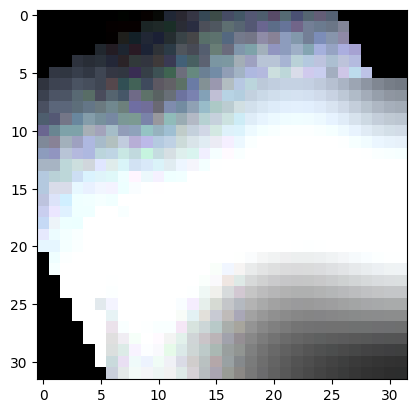

In [109]:
plt.imshow(misclassified_images[0])

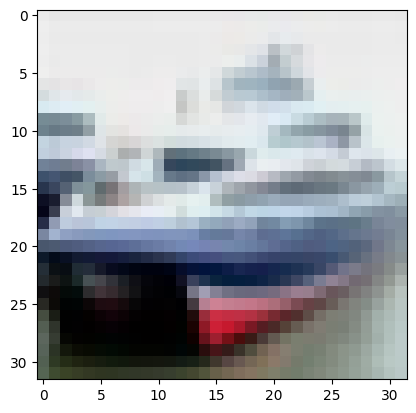

In [110]:
plt.imshow(misclassified_true_images[0])